In [1]:
import os
import io
from time import time
from datetime import datetime
import itertools
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #set to -1 to disable gpu (on fresh kernel)

In [2]:
import tensorflow as tf
import keras
import keras.backend as K

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()
# tf.test.is_gpu_available()

[]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
os.chdir(r"../immediate_results")

In [6]:
df = pd.read_csv(r"cleandf_40days_930_to_1830_lin_interpolated.csv")

In [7]:
df[:10]

CAMERA_ID            TIMESTAMP   GEO_LON    GEO_LAT  DENSITY_VALUE
0          4  2010-10-11 09:30:00 -0.227278  51.491661   53547.356500
1          4  2010-10-11 10:00:00 -0.227278  51.491661   46199.700875
2          4  2010-10-11 10:30:00 -0.227278  51.491661   39602.705900
3          4  2010-10-11 11:00:00 -0.227278  51.491661   27179.430333
4          4  2010-10-11 11:30:00 -0.227278  51.491661   23527.222300
5          4  2010-10-11 12:00:00 -0.227278  51.491661   19940.461500
6          4  2010-10-11 12:30:00 -0.227278  51.491661   20405.220000
7          4  2010-10-11 13:00:00 -0.227278  51.491661   21775.247000
8          4  2010-10-11 13:30:00 -0.227278  51.491661   18727.309900
9          4  2010-10-11 14:00:00 -0.227278  51.491661   17784.156700

In [8]:
onedf = df.groupby("CAMERA_ID").first()

In [9]:
onedf[:5]

TIMESTAMP   GEO_LON    GEO_LAT  DENSITY_VALUE
CAMERA_ID                                                         
4          2010-10-11 09:30:00 -0.227278  51.491661     53547.3565
5          2010-10-11 09:30:00 -0.206961  51.490687     47421.4965
6          2010-10-11 09:30:00 -0.222113  51.491302     43406.3555
7          2010-10-11 09:30:00 -0.252217  51.487000     56276.9610
8          2010-10-11 09:30:00 -0.223876  51.492963     64193.1710

In [10]:
from sklearn.metrics import pairwise_distances

In [11]:
distances = pairwise_distances(onedf[["GEO_LON","GEO_LAT"]])

In [12]:
closest_cam_indices = {}
for i in range(distances.shape[0]):
    closest_cam_indices[i] = np.argsort(distances[i,:])

In [13]:
closest_cam_indices

{0: array([ 0,  4,  2,  1,  5,  3, 38, 36, 35, 42, 53, 50, 52, 47, 48, 39, 34,
        46, 40, 44, 45, 49, 37, 31, 51, 57, 32, 43, 26, 27, 28, 41, 54, 29,
        16, 17, 22, 25, 19, 18, 55,  9, 11, 33, 20, 15, 10,  6, 14, 13, 12,
        21, 23,  8, 56, 30,  7, 24], dtype=int64),
 1: array([ 1,  2,  4,  0, 50, 53, 42, 47, 35, 38,  5, 48,  3, 36, 34, 46, 44,
        45, 49, 52, 39, 31, 57, 40, 43, 32, 37, 26, 27, 28, 51, 29, 16, 17,
        22, 25, 18, 19, 41, 54,  9, 11, 20, 33, 10, 15, 55,  6, 14, 13, 12,
        23, 21,  8, 30, 56,  7, 24], dtype=int64),
 2: array([ 2,  4,  0,  1,  5,  3, 38, 35, 42, 53, 36, 50, 47, 48, 52, 39, 34,
        46, 44, 45, 40, 49, 31, 37, 57, 51, 43, 32, 26, 27, 28, 41, 29, 16,
        17, 22, 25, 54, 18, 19, 55,  9, 11, 33, 20, 10, 15,  6, 14, 13, 12,
        21, 23,  8, 56, 30,  7, 24], dtype=int64),
 3: array([ 3,  5,  0,  4,  2, 52,  1, 36, 39, 38, 35, 42, 40, 51, 53, 50, 47,
        48, 37, 34, 46, 44, 45, 49, 54, 31, 41, 57, 32, 43, 26, 55, 27, 28,

In [14]:
# df.DENSITY_VALUE = np.log(df.DENSITY_VALUE)
df.DENSITY_VALUE -= df.DENSITY_VALUE.min()
df.DENSITY_VALUE /= df.DENSITY_VALUE.max() # scaling to [0,1]
df = df.pivot(index="TIMESTAMP",columns="CAMERA_ID",values="DENSITY_VALUE")
L = int(0.75 * len(df)) #3/4 of the length of data (over time) to be used as train and what ever comes after this would be for evaluation

In [15]:
df

CAMERA_ID                 4         5         6         7         8    \
TIMESTAMP                                                               
2010-10-11 09:30:00  0.832721  0.736465  0.673375  0.875612  1.000000   
2010-10-11 10:00:00  0.717267  0.677046  0.539202  0.536337  0.928692   
2010-10-11 10:30:00  0.613608  0.580922  0.429255  0.479447  0.857383   
2010-10-11 11:00:00  0.418400  0.434257  0.266390  0.339875  0.725234   
2010-10-11 11:30:00  0.361012  0.404033  0.204576  0.306596  0.321575   
2010-10-11 12:00:00  0.304653  0.428367  0.183852  0.274417  0.289617   
2010-10-11 12:30:00  0.311956  0.304918  0.206830  0.266901  0.291421   
2010-10-11 13:00:00  0.333483  0.316085  0.242929  0.242035  0.285842   
2010-10-11 13:30:00  0.285591  0.366087  0.161221  0.244930  0.305829   
2010-10-11 14:00:00  0.270771  0.277595  0.120844  0.226747  0.304305   
2010-10-11 14:30:00  0.341074  0.261700  0.137740  0.218907  0.317512   
2010-10-11 15:00:00  0.340054  0.229100  0.138745  0.260715  0.348867   
2010-10-11 15:30:00  0.423740  0.220598  0.203397  0.377745  0.419855   
2010-10-11 16:00:00  0.446975  0.241334  0.160889  0.402249  0.513418   
2010-10-11 16:30:00  0.541662  0.373131  0.179553  0.452027  0.634326   
2010-10-11 17:00:00  0.623828  0.570275  0.421990  0.577903  0.686852   
2010-10-11 17:30:00  0.560180  0.649326  0.449701  0.601893  0.650849   
2010-10-11 18:00:00  0.479465  0.583546  0.507219  0.368292  0.548068   
2010-10-11 18:30:00  0.628765  0.642776  0.650817  0.734953  0.703240   
2010-10-12 09:30:00  0.406132  0.432930  0.527475  0.311408  0.440725   
2010-10-12 10:00:00  0.394718  0.422405  0.492325  0.321751  0.387691   
2010-10-12 10:30:00  0.392652  0.406920  0.370317  0.259585  0.292303   
2010-10-12 11:00:00  0.350642  0.374163  0.342122  0.231752  0.261941   
2010-10-12 11:30:00  0.377405  0.408138  0.316887  0.222012  0.282189   
2010-10-12 12:00:00  0.329586  0.327265  0.299036  0.263719  0.256575   
2010-10-12 12:30:00  0.283286  0.299494  0.354648  0.235572  0.246865   
2010-10-12 13:00:00  0.267242  0.295020  0.316561  0.288581  0.269757   
2010-10-12 13:30:00  0.223575  0.271862  0.322887  0.327436  0.297633   
2010-10-12 14:00:00  0.185948  0.245146  0.319398  0.343789  0.259786   
2010-10-12 14:30:00  0.181039  0.239531  0.266494  0.309499  0.328422   
...                       ...       ...       ...       ...       ...   
2010-11-21 13:30:00  0.113510  0.230744  0.109129  0.061064  0.079682   
2010-11-21 14:00:00  0.156925  0.237202  0.288286  0.073161  0.080484   
2010-11-21 14:30:00  0.067753  0.219193  0.094437  0.070939  0.168746   
2010-11-21 15:00:00  0.068327  0.203660  0.091436  0.062752  0.126965   
2010-11-21 15:30:00  0.092746  0.214257  0.125261  0.092806  0.169692   
2010-11-21 16:00:00  0.286689  0.291706  0.427269  0.530477  0.516520   
2010-11-21 16:30:00  0.466970  0.267430  0.619214  0.550645  0.730653   
2010-11-21 17:00:00  0.432327  0.219004  0.492477  0.384737  0.669440   
2010-11-21 17:30:00  0.354311  0.210346  0.400935  0.314949  0.639246   
2010-11-21 18:00:00  0.327625  0.225696  0.376124  0.277541  0.592714   
2010-11-21 18:30:00  0.277184  0.245703  0.337465  0.254163  0.667740   
2010-11-22 09:30:00  0.471847  0.382561  0.208767  0.346169  0.157123   
2010-11-22 10:00:00  0.240212  0.281684  0.139550  0.162721  0.128547   
2010-11-22 10:30:00  0.190738  0.288075  0.118425  0.229427  0.138285   
2010-11-22 11:00:00  0.156867  0.247803  0.116203  0.093070  0.151848   
2010-11-22 11:30:00  0.117920  0.236391  0.062228  0.097277  0.110819   
2010-11-22 12:00:00  0.101493  0.270458  0.130093  0.118414  0.322923   
2010-11-22 12:30:00  0.125826  0.234036  0.087783  0.139552  0.247877   
2010-11-22 13:00:00  0.078169  0.215753  0.104974  0.160689  0.211875   
2010-11-22 13:30:00  0.108529  0.268844  0.136086  0.181826  0.278216   
2010-11-22 14:00:00  0.132704  0.264259  0.148662  0.202963  0.272539   
2010-11-22 14:30:00  0.147792  0.268457  0.096696  0.29897

In [16]:
#this is how to get K closest.
df.iloc[:,closest_cam_indices[0][:5]] [:2]

CAMERA_ID                   4         8         6         5         9
TIMESTAMP                                                            
2010-10-11 09:30:00  0.832721  1.000000  0.673375  0.736465  0.722307
2010-10-11 10:00:00  0.717267  0.928692  0.539202  0.677046  0.588867

In [17]:
import seaborn as sns

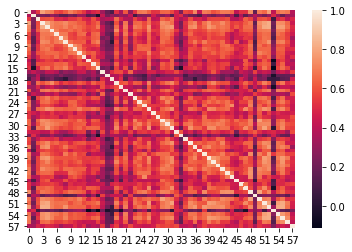

In [18]:
sns.heatmap(np.corrcoef(df,rowvar=False))

In [19]:
from keras import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import Adam, RMSprop 
from keras import regularizers

from keras.layers import Input, Concatenate, Reshape, Lambda, Dropout
from keras.layers import TimeDistributed, Bidirectional
from keras.models import Model

from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

In [29]:
BATCH_SIZE = 1

In [33]:
def get_data_generator_N_to_M(df, input_cameras_index_list, target_cameras_index_list, timesteps, mode = "train"):
    if mode == "train":
        while True:
            for i in range(0, L - timesteps):
                X = np.reshape(df.iloc[i:i+timesteps, input_cameras_index_list].values,
                               newshape=(BATCH_SIZE, timesteps, len(input_cameras_index_list)) )
                y = np.reshape(df.iloc[i+timesteps, target_cameras_index_list].values,
                               newshape = (BATCH_SIZE, len(target_cameras_index_list)) )
                yield (X,y)
                               
    elif mode == "eval":
        while True:
            for i in range(L - timesteps, len(df) - timesteps):
                X = np.reshape(df.iloc[i:i+timesteps, input_cameras_index_list].values,
                               newshape=(BATCH_SIZE, timesteps, len(input_cameras_index_list)) )
                y = np.reshape(df.iloc[i+timesteps, target_cameras_index_list].values,
                               newshape = (BATCH_SIZE, len(target_cameras_index_list)) )
                yield (X,y)
            
                

In [22]:
#you can use my code here from the all cameras model I'm working on. 
#function returns layer objects you need to add to your model where you need an LSTM block.
#It supports stacking up to 3 lstms and bidirectional lstm wrapper.
#assuming the model = Sequential()
#layers = get_lstm_layers(params)
#for layer in layers:
#    model.add(layer)
def get_lstm_layers(params):
    """returns keras tensor output of a block of stateful lstms (potentially stacked)."""
    n = params["stack_lstm_count"]

    layers = []
    
    lstm1 = LSTM( params["lstm1_units"],
                     batch_input_shape=(1,params["timesteps"],params["dense_units"]), 
                     stateful=True,
                     return_sequences= True if n > 1 else False,
                     dropout=params["lstm1_dropout"],
                     recurrent_dropout=params["lstm1_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm1_l2reg"]),
                )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm1 = Bidirectional(lstm1) #default mode is concat

    layers.append(lstm1)
                 
    if n == 1:
        return layers
        
    lstm2 = LSTM(params["lstm2_units"],
                     stateful=True,
                     return_sequences = True if n > 2 else False,
                     dropout=params["lstm2_dropout"],
                     recurrent_dropout=params["lstm2_recurrent_dropout"],
                     activity_regularizer=regularizers.l2(l=params["lstm2_l2reg"]),
                    )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm2 = Bidirectional(lstm2) #default mode is concat  
    
    layers.append(lstm2)
                 
    if n == 2:
        return layers
                
    
    lstm3 = LSTM(params["lstm3_units"],
                stateful=True,
                return_sequences=False,
                dropout=params["lstm3_dropout"],
                recurrent_dropout=params["lstm3_recurrent_dropout"],
                activity_regularizer=regularizers.l2(l=params["lstm3_l2reg"]),
               )
                 
    if "bidirectional_lstms" in params and params["bidirectional_lstms"] == True:
        lstm3 = Bidirectional(lstm3) #default mode is concat  
                 
    layers.append(lstm3)
                 
    return layers

In [23]:
def exp_loss(yTrue,yPred):
    return K.mean(K.exp(K.square(yTrue - yPred,)))

In [53]:
def get_model(params):
    model = Sequential()
#     model.add(Bidirectional(LSTM(units=params["lstm_units"],
#                    stateful=True, 
#                    input_shape = (params["timesteps"],params["K"]),
#                    batch_size = params["batch_size"] ), batch_input_shape=(params["batch_size"],params["timesteps"],params["K"])) )
    model.add(LSTM(units=params["lstm_units"],
                   stateful=True, 
                   input_shape = (params["timesteps"], params["input_N"]),
                   batch_size = params["batch_size"]) )

    model.add(Dense(units=params["output_M"], activation="sigmoid"))
    
    return model

In [69]:
NUM_CAMERAS = len(df.columns)

In [98]:
np.random.seed(0)
in_list = np.random.choice(range(NUM_CAMERAS),size = NUM_CAMERAS//58, replace= False).tolist()
out_list = [x for x in range(NUM_CAMERAS) if x not in in_list]

In [99]:
paramss = []
paramss.append({"timesteps" : 10, "input_N" : len(in_list), "output_M" : len(out_list),
                "batch_size" : 1, "lstm_units" : 120})

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (1, 120)                  58560     
_________________________________________________________________
dense_5 (Dense)              (1, 57)                   6897      
Total params: 65,457
Trainable params: 65,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/250
560/560 [==============================] - 3s 5ms/step - loss: 0.0113 - mean_absolute_percentage_error: 34.5303 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 17868.7671
Epoch 2/250
560/560 [==============================] - 2s 4ms/step - loss: 0.0112 - mean_absolute_percentage_error: 35.3710 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 18100.4748
Epoch 3/250
560/560 [==============================] - 2s 4ms/step - loss: 0.0111 - mean_absolute_percentage_error: 35.5341 - val_loss: 0.0222 - 

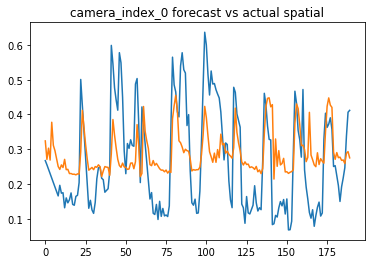

In [100]:
CURRENT_TIME = datetime.now().strftime("%Y-%m-%d %H-%M")

for params in paramss: 
    
    model = get_model(params)

    model.compile(optimizer=Adam(lr=0.001,clipnorm=1.), loss="mse", metrics=["mape"])

    print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)
    
    es = EarlyStopping(monitor="val_loss", patience=10, min_delta=0.0001, restore_best_weights=True)
        
    train_gen = get_data_generator_N_to_M(df, 
                                          in_list, 
                                          out_list, 
                                          params["timesteps"],
                                          mode = "train")
    #don't reuse generator as it might be messed up.
    
    val_gen = get_data_generator_N_to_M(df, 
                                          in_list, 
                                          out_list, 
                                          params["timesteps"],
                                          mode = "eval")
    
    one_test = itertools.islice(val_gen, len(df) - L) #it should be fine as it is one whole eval epoch
    
    history = model.fit_generator(train_gen,
                                  epochs = 250,
                                  steps_per_epoch= L-params["timesteps"],
                                  validation_data = val_gen,
                                  validation_steps = len(df) - L,
                                  callbacks=[es] #tensorboard goes here
                                 )
    
    a = list(one_test)
    X, y = zip(*a)
    X = np.array(X).reshape(len(df)-L, params["timesteps"], params["input_N"])
    y = np.array(y).reshape(len(df)-L, params["output_M"])
    print(X.shape,y.shape)
    
    predictions = model.predict(X, batch_size=1)
    
    mses = []
    for i in range(y.shape[1]):
        mses.append(np.mean(np.square(y[:,i] - predictions[:,i])))
        
    plt.plot(y[:,0])
    plt.plot(predictions[:,0])
    plt.title("camera_index_0 forecast vs actual spatial")
    plt.show()
    
#     del model 
#     del history
#     K.clear_session() #to hopefully prevent slow down after a few models have run..

In [101]:
mses

[0.015476157864254428,
 0.008500141595284888,
 0.020053268298856917,
 0.025380719697084213,
 0.023755889317058458,
 0.02347122475746545,
 0.023459051044500603,
 0.01106668272584682,
 0.016587375295089354,
 0.010645241848171706,
 0.013777175686340685,
 0.011388410139917876,
 0.011299487246412554,
 0.020453922190764456,
 0.01979101476954859,
 0.02234272058537082,
 0.011131258840559507,
 0.022392165957737045,
 0.007329437911266543,
 0.015768106174752456,
 0.007231922195192773,
 0.014940537325594977,
 0.0072691312956381085,
 0.027540580955577373,
 0.011003207827853433,
 0.006753421115466621,
 0.013748388172301788,
 0.005778947727914739,
 0.020481594791025237,
 0.027292012294974435,
 0.013405422679877087,
 0.009876221560531747,
 0.003634910710461923,
 0.005992055781640254,
 0.02726244696650638,
 0.014346672430029222,
 0.017663408331479283,
 0.010975000531104128,
 0.012647866255280946,
 0.014514695837222008,
 0.013776787956086818,
 0.015170765939683719,
 0.016788648185744957,
 0.014831664794

In [97]:
mses

[0.00824148108257624,
 0.006580669453720786,
 0.017310491104649064,
 0.012554424404672975,
 0.015039574945362016,
 0.00860446605395665,
 0.008131777241210851,
 0.005414520918726236,
 0.0068144763113708266,
 0.019238758306001344,
 0.013002910778295391,
 0.012362560133724073,
 0.009104933791357604,
 0.018967113843747916,
 0.0056374696080975385,
 0.012768378123917186,
 0.005637323081801037,
 0.009765421275659221,
 0.02122193966818119,
 0.008018291845822693,
 0.004636952540056134,
 0.009159036094888492,
 0.013820366832173114,
 0.008685902709262944,
 0.007813778897150724,
 0.0024978776093301995,
 0.011126275956609035,
 0.014499640024966088,
 0.0048817261971417485,
 0.010818205112890934,
 0.007953665841995273,
 0.01257132762471079,
 0.009948736227476654,
 0.002449987758489427,
 0.004867317547807499,
 0.004289156497331432,
 0.008674265835971173,
 0.011433354797075522,
 0.015252611681408167,
 0.006519085242019266,
 0.007600371229241569,
 0.01067264119448019,
 0.00850460751326401,
 0.0052273714

### Notes